This is an example script for running the microcircuit model and generating basic plots of the network activity.

Import the necessary modules and start the time measurements.

In [1]:
import time
import nest
import network
import addons
import helpers
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Initialize the network with simulation, network and stimulation parameters, then create and connect all nodes, and finally simulate. The times for a presimulation and the main simulation are taken independently. A presimulation is useful because the spike activity typically exhibits a startup transient. In benchmark simulations, this transient should be excluded from a time measurement of the state propagation phase. Besides, statistical measures of the spike activity should only be computed after the transient has passed.

In [2]:
net = network.Network(sim_dict, net_dict, stim_dict)
time_network = time.time()

net.create()
time_create = time.time()

Data will be written to: /home/hyc_1/CorticalColumn_Github_1/CorticalColumn_Attempts/data_og/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jan 15 17:00:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.


In [3]:
net.connect()
time_connect = time.time()

Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065, first=58762, last=59826)
NodeCollection(metadata=None, model=iaf_psc_exp, size=14395, first=59827, last=74221)
NodeCollection(metadata=None, model=iaf_psc_exp, size=2948, first=74222, last=77169)
NodeCollection(metadata=None, model=iaf_psc_exp, size=902, first=77170, last=78071)
NodeCollection(metadata=None, model=iaf_psc_exp, size=301, first=78072, last=78372)
Connecting Poisson generators for background input.

Jan 15 17:00:31 NodeManager::prepare_nodes [Info]: 
   

In [4]:
### Let's attempt to get the number of connections that go into the first 500 neurons of each population
data_synapses = addons.number_synapses(net.pops)

 pop: 0 
 neuron: 50 Mean:[3428.28 1554.22]Standard deviation:[63.47032062 44.23767173]Maximum:[3553 1633]Minimum:[3258 1450]
 pop: 1 
 neuron: 20733 Mean:[4148.62 1156.98]Standard deviation:[60.1983023  29.70016162]Maximum:[4293 1221]Minimum:[4031 1072]
 pop: 2 
 neuron: 26567 Mean:[2068.52  834.7 ]Standard deviation:[48.59186763 30.6954394 ]Maximum:[2210  906]Minimum:[1985  738]
 pop: 3 
 neuron: 48482 Mean:[4969.32  974.1 ]Standard deviation:[62.12099162 30.18227957]Maximum:[5130 1049]Minimum:[4857  905]
 pop: 4 
 neuron: 53961 Mean:[4025.62  903.82]Standard deviation:[76.264773   27.51922237]Maximum:[4193  969]Minimum:[3900  825]
 pop: 5 
 neuron: 58811 Mean:[2158.58  577.94]Standard deviation:[44.11715766 24.88405915]Maximum:[2267  633]Minimum:[2085  529]
 pop: 6 
 neuron: 59876 Mean:[1700.12  912.44]Standard deviation:[36.06418722 33.39290943]Maximum:[1767  993]Minimum:[1617  833]
 pop: 7 
 neuron: 74271 Mean:[1974.66  481.  ]Standard deviation:[43.44910126 23.8117618 ]Maximum:[2

In [5]:
net.simulate(sim_dict["t_presim"])
time_presimulate = time.time()

Simulating 500.0 ms.

Jan 15 17:02:38 NodeManager::prepare_nodes [Info]: 
    Preparing 78872 nodes for simulation.

Jan 15 17:02:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78872
    Simulation time (ms): 500
    Number of OpenMP threads: 10
    Number of MPI processes: 1

Jan 15 17:03:05 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
net.simulate(sim_dict["t_sim"])
time_simulate = time.time()

Simulating 5000.0 ms.

Jan 15 17:03:05 NodeManager::prepare_nodes [Info]: 
    Preparing 78872 nodes for simulation.

Jan 15 17:03:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78872
    Simulation time (ms): 5000
    Number of OpenMP threads: 10
    Number of MPI processes: 1

Jan 15 17:08:58 SimulationManager::run [Info]: 
    Simulation finished.


Plot a spike raster of the simulated neurons and a box plot of the firing rates for each population. For visual purposes only, spikes 100 ms before and 100 ms after the thalamic stimulus time are plotted here by default. The computation of spike rates discards the presimulation time to exclude initialization artifacts.

Interval to plot spikes: [600 800] ms
['spike_recorder-78373', 'spike_recorder-78374', 'spike_recorder-78375', 'spike_recorder-78376', 'spike_recorder-78377', 'spike_recorder-78378', 'spike_recorder-78379', 'spike_recorder-78380', 'spike_recorder-78381', 'spike_recorder-78382']
Interval to compute firing rates: [ 500 2500] ms
Mean rates: [ 0.513  2.161  3.568  5.944  5.552  7.954  1.15   7.62  10.65   1.678] spikes/s
Standard deviation of rates: [0.721 1.729 2.835 3.914 3.932 4.705 1.49  4.621 1.95  0.871] spikes/s


/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning:invalid value encountered in log10


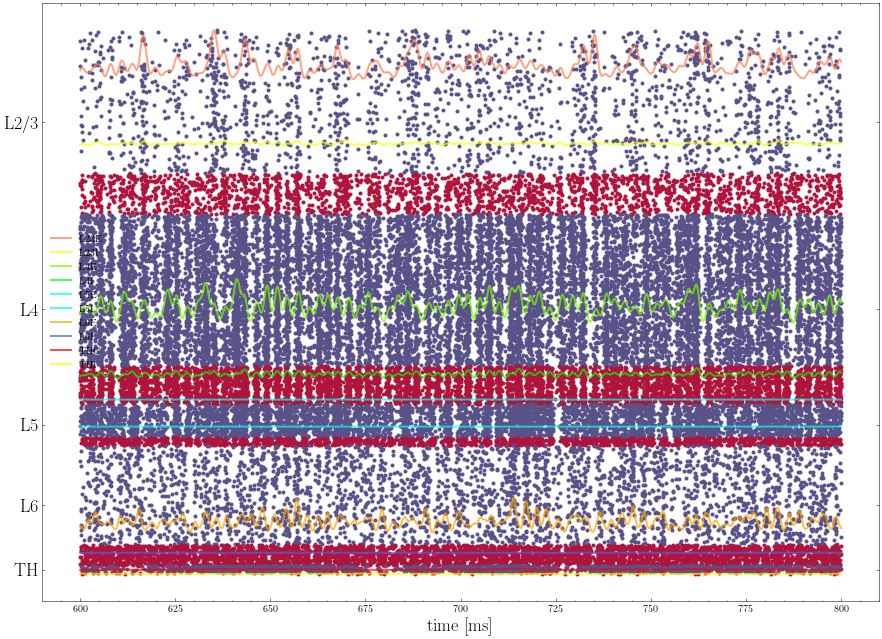

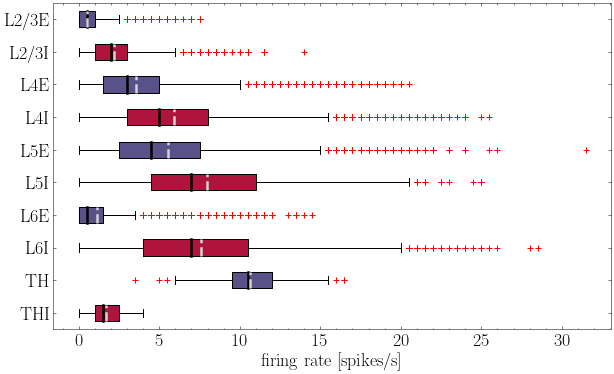

In [7]:
raster_plot_interval = np.array([600, 800])
firing_rates_interval = np.array([500,2500])
pop_activity = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True)
time_evaluate = time.time()